## Question A4: Map locations offering kapsalons and their average price.
--> also added the count per location of restaurants having 'kapsalon' on the menu

#### TakeAway

In [20]:
query_a4_resto_takeaway = """
    SELECT
        restaurants.primarySlug, restaurants.name, restaurants.latitude, restaurants.longitude,
        AVG(CASE WHEN menuItems.name LIKE '%kapsalon%' THEN menuItems.price ELSE NULL END) AS avg_kapsalon_price,
        COUNT(CASE WHEN menuItems.name LIKE '%kapsalon%' THEN menuItems.price ELSE NULL END) AS count_kapsalon_options
    FROM
        restaurants
    JOIN 
        menuItems ON restaurants.primarySlug = menuItems.primarySlug
    WHERE
        menuItems.name LIKE '%kapsalon%'
    GROUP BY
        restaurants.primarySlug
    ORDER BY
	    avg_kapsalon_price DESC;
"""

### Connect to the database and excute the query --> method: read_sql_query

In [21]:
import sqlite3
import pandas as pd


# database_paths
deliveroo_db = r"..\databases\deliveroo.db"
takeaway_db = r"..\databases\takeaway.db"
ubereats_db = r"..\databases\ubereats.db"

# set the variables for query and database
database = takeaway_db

# Connect to the deliveroo database
connection = sqlite3.connect(database)

# Execute queries and assign to dataframe
#df_a4_deli = pd.read_sql_query(query_a4_deli, connection)
#df_b3_deli = pd.read_sql_query(query_b3_deli, connection)
#df_a4b3_deli = pd.read_sql_query(query_a4b3_deli, connection)
df_a4_resto_takeaway = pd.read_sql_query(query_a4_resto_takeaway, connection)
#df_b1_deliveroo = pd.read_sql_query(query_b1_deliveroo, connection)

# Close the connection to the database (this may help avoiding database locks)
connection.close()

# Print the whole shebang
#print("Query df_a4_deli: ", df_a4_deli.head())
#print("Query df_b3_deli: ", df_b3_deli.head())
#print("Query df_a4b3_deli: ", df_a4b3_deli.head())
print("Query df_a4_resto_takeaway: ", df_a4_resto_takeaway.head())
#print("Query df_b1_deliveroo: ", df_b1_deliveroo.head())

Query df_a4_resto_takeaway:              primarySlug                          name   latitude  longitude  \
0       melita-original               Melita Original  50.905063   3.528835   
1          cannur-kebab  Cannur Pizza Pasta Pitta BBQ  51.005845   3.888688   
2         anatolia-2320          Anatolia Hoogstraten  51.396100   4.753590   
3  flamingo-pizza-kebap        Flamingo Pizza & Kebap  51.355780   4.865092   
4            qubbe-bvba                  Qubbe Lounge  50.979642   5.491545   

   avg_kapsalon_price  count_kapsalon_options  
0           22.785714                       7  
1           20.844000                      10  
2           19.166667                       9  
3           17.350000                      10  
4           16.000000                       2  


#### Distribution of the average prices for a kapsalon per restaurant

In [22]:
df = df_a4_resto_takeaway
column = "avg_kapsalon_price"
groups = ['avg_kapsalon_price']

minimum = df[column].min()
mean = df[column].mean()
maximum = df[column].max()
#som = df_agg[column].sum()

print("Minimum value: ", minimum)
print("Mean value: ", mean)
print("Maximum value: ", maximum)
#print("Totaal: ", som)

print(df[column].agg(['count','skew','mean','median', 'min', 'max']))
count,skew,mean,median,mini,maxi = df[column].agg(['count','skew','mean','median', 'min', 'max'])
print(count,skew,mean,median,mini,maxi)
print(df['name'][df[column] == mini])
print(df['name'][df[column] == maxi])


Minimum value:  5.0
Mean value:  10.785014778973599
Maximum value:  22.785714285714285
count     867.000000
skew        0.501775
mean       10.785015
median     10.833333
min         5.000000
max        22.785714
Name: avg_kapsalon_price, dtype: float64
867.0 0.5017746857594648 10.785014778973599 10.833333333333334 5.0 22.785714285714285
866    Öz Ahi Döner
Name: name, dtype: object
0    Melita Original
Name: name, dtype: object


<Axes: ylabel='avg_kapsalon_price'>

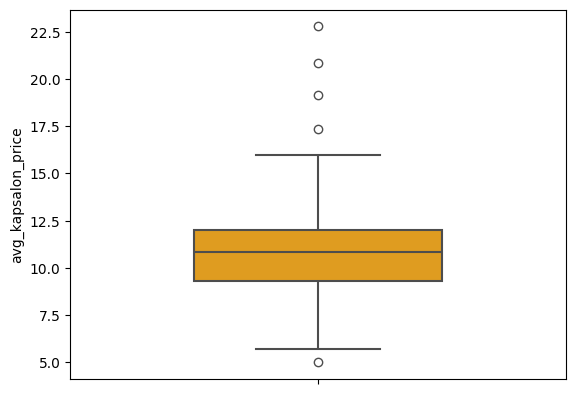

In [23]:
import seaborn as sns
sns.boxplot(data=df_a4_resto_takeaway, y='avg_kapsalon_price', color='orange', linewidth=1.5, width=0.5)

#### Create a plot with color scale (green to dark red) with increasing value


In [24]:
import folium
import pandas as pd
import branca

df = df_a4_resto_takeaway
value_column = 'avg_kapsalon_price'
value_column_2 = 'count_kapsalon_options'
caption = "Average price for kapsalon in €"
q1 = df[value_column].quantile(0.25)
q2 = df[value_column].quantile(0.50)
q3 = df[value_column].quantile(0.75)


# Step : Define count ranges and assign colors
def price_color(value):
    if value < q1:
        return 'green'
    elif value < q2:
        return 'orange'
    elif value < q3:
        return 'red'
    else:
        return 'darkred'

# Step : Create a map with Folium
m = folium.Map(location=[51.02804780556587, 4.478784607950115], zoom_start=9)  # Centered on Mechelen (only Flanders data)

# Step : Adding markers for each point of interest with count per location information
for i, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # You can adjust the size of the marker based on the average price
        popup=f"Resto: {row['name']}<br>Price: {round(row[value_column],2)}<br>Nr of options: {row[value_column_2]}",
        color=price_color(row[value_column]),  # Use the function to determine the color
        fill=True,
        fill_color=price_color(row[value_column]),
        fill_opacity=0.6
    ).add_to(m)

# Step : Create a legend
color_scale = branca.colormap.StepColormap(['green', 'orange', 'red', 'darkred'], 
                                             vmin=mini, vmax=maxi, 
                                             index=[0, q1, q2, q3, maxi], 
                                             caption=caption)

# Add the legend to the map
color_scale.add_to(m)

# Step : Save the map to an HTML file
m.save("../assets/geo/kapsalon_per_restaurant_takeaway.html")

# You can now open the HTML file to see the map




### Create a static map of Belgium with 1 value

In [25]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
from shapely.geometry import Point


Text(0.5, 1.0, 'Average price for kapsalon in €')

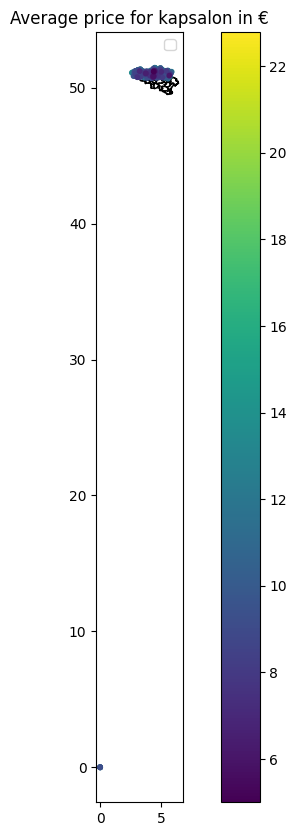

In [26]:
# Load data (already done above)

# Creating point geometry with Longitude and Latitude
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Setting the reference frame (CRS), e.g. EPSG:4326
gdf.set_crs(epsg=4326, inplace=True)

# Load administrative boundaries (e.g. Belgium)
# Replace 'path/to/belgium_shapefile.shp' with the path to your file
# Downloaded from: https://gadm.org/download_country.html#google_vignette
borders = gpd.read_file(r"..\assets\geo\gadm41_BEL_3.shp")

# Set the frame of reference for the boundaries if different (for example EPSG:4326)
#borders = borders.to_crs(epsg=4326)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Draw administrative boundaries on the map
borders.plot(ax = ax, color='white', edgecolor='black', linewidth=1) 

# Draw price points (Price)
scatter = gdf.plot(ax=ax, 
                   column=value_column, 
                   cmap='viridis',  # Color map
                   legend=True, 
                   markersize=10)

# Add a legend
handles, labels = scatter.get_legend_handles_labels()
ax.legend(handles, [f'{int(float(label))}' for label in labels])


plt.title(caption)
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.grid()
#plt.show()

### Interactive map of Belgium

In [27]:
import folium
from folium.plugins import MarkerCluster
import webbrowser

# Remove rows that have NaN in the latitude or longitude columns
df_clean = df.dropna(subset=['latitude', 'longitude'])

# Create a map with the appropriate center
properties = folium.Map(location=[df_clean['latitude'].mean(), df_clean['longitude'].mean()], zoom_start=9)

folium.TileLayer('Stamen Toner', attr='Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap').add_to(properties)

# Add MarkerCluster to improve performance with large numbers of markers
marker_cluster = MarkerCluster().add_to(properties)

# Add tags to the cluster
for index, row in df_clean.iterrows():
    # This is where you add the text and values you want to display on click
    text = f"""
    Price: {round(row.avg_kapsalon_price,2)} €<br>
    Nr of options: {row.count_kapsalon_options}<br>   
    """
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=folium.Popup(text, max_width=400),
        tooltip=round(row.avg_kapsalon_price,2) # This is where you add the text and values you want to display on hover over
    ).add_to(marker_cluster)

properties

# Save map to the html
map_path = r"..\assets\geo\kapsalon_per_restaurant_takeaway_interactive.html"
properties.save(map_path)

# Open map in browser
webbrowser.open(map_path)


True